In [2]:
from bs4 import BeautifulSoup
import requests
import time
import pandas as pd
import numpy as np
from langdetect import detect
import re

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.probability import FreqDist

from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings('ignore')

# About
Can a computer can tell the genre of a song based on his lyrics? <br><br>

My goal here is to build a model that can predict from 4 different genre, the genre of a song based on his lyrics. <br>
The genres i decided to focus on are Rock, Hip Hop, Electronic and Reggae. <br>
I am using the "bag of words" approach, wish is making a model based on words frequencies in the corpus.

## Acknoledgement
I got the data from the brazilian website:   www.vagalume.com.br <br> 
A great website with plenty of lyrics organized by genre.

# Getting the data
The first step is to get the data. <br>
The next function crawl the website using 'requests' and 'BeautifulSoup'.

In [ ]:
def crawler(base_url, genre_url, genre):
    artists = []
    songs_name = []
    lyrics = []
    
    genre_page_html = requests.get(genre_url) #request genre page html
    time.sleep(3)
    soup = BeautifulSoup(genre_page_html.content,'html.parser') 
    artists_list = soup('ul', attrs={'class':'namesColumn'})
    artists_href = []
    for i in range(len(artists_list)):
        artists_href+= [t['href'] for t in artists_list[i]('a')]
        
    urls_to_artists = [base_url+href for href in artists_href]
    
    for i in range(len(urls_to_artists)):
        try:
            artist_page_html = requests.get(urls_to_artists[i])
            time.sleep(3)
            soup = BeautifulSoup(artist_page_html.content, 'html.parser')
            songs_html = soup.find(id='alfabetMusicList')
            songs_href = [t['href'] for t in songs_html.findAll(class_='nameMusic')]
            urls_to_songs = [base_url+href for href in songs_href]
        except:
            continue       
        for url in urls_to_songs:
            try:
                song_page_html = requests.get(url)
                time.sleep(3)
                soup = BeautifulSoup(song_page_html.content, 'html.parser')
                song_name = soup.find(id='lyricContent')('h1')[0].get_text()
                artist = soup.find(id='lyricContent')('h2')[0].get_text()
                lyrics_ = soup.find(id='lyrics').get_text("\n")
            except:
                continue
                
            songs_name.append(song_name)
            artists.append(artist)
            lyrics.append(lyrics_)
            
        if(i%5==0):
            df = pd.DataFrame({'Artist': artists, 'Song': songs_name, 'Lyrics': lyrics, 'Genre': genre })
            df.to_csv(str(genre)+'.csv')
    df = pd.DataFrame({'Artist': artists, 'Song': songs_name, 'Lyrics': lyrics, 'Genre': genre })
    df.to_csv(str(genre)+'.csv')

In [ ]:
base_url = 'https://www.vagalume.com.br'
crawler(base_url, 'https://www.vagalume.com.br/browse/style/rock.html', 'Rock')
crawler(base_url, 'https://www.vagalume.com.br/browse/style/reggae.html', 'Reggae')
crawler(base_url, 'https://www.vagalume.com.br/browse/style/hip-hop.html', 'Hip Hop')
# crawler(base_url, 'https://www.vagalume.com.br/browse/style/electronica.html', 'Electronic')
crawler(base_url, 'https://www.vagalume.com.br/browse/style/soul-music.html', 'Soul')

It took me a couple of days to crawl the data since i had internet connection issues.. <br>
But now i have a the genre i want i can create 1 unified dataframe

In [4]:
# df1 = pd.read_csv('Soul.csv')
# df2 = pd.read_csv('hip_hop.csv')
# df3 = pd.read_csv('reggae.csv')
# df4 = pd.read_csv('rock.csv')
# df= pd.concat([df1,df2,df3,df4], ignore_index=True)
# df.to_csv('row_data.csv')
df = pd.read_csv('row_data.csv', index_col=[0])
df.shape

(49510, 4)

It took me a couple of days to get all the data i needed, but now i have a dataframe of almost 50,000 lyrics <br>

# Data cleaning
Now its time to clean the data. <br>
As a brazilian website vagalume has many brazilian songs. <br>
I filter the lyrics by keeping english lyrics only.<br>
I use a language detecter from python lybraries.

In [ ]:
# df = pd.read_csv('row_data.csv')
#language detection
for i in df.index:
    if detect(df['Lyrics'][i])!='en':
        df.drop(i, inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

I noticed there are couple of artists with multiple labels. <br>
I decided to get ride of them.

In [239]:
# df = pd.read_csv('data_just_english.csv', index_col=[0])
# df=df[df['Genre']!='Electronic']
df.reset_index(drop=True, inplace=True)
for artist in df['Artist'].unique():
    if len(df[df['Artist']==artist]['Genre'].unique())>1: #if artist has more than one label
        df.drop(df[df['Artist']==artist].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

I might have empty lyrics or duplicated ones.

In [ ]:
df.drop(df[df['Lyrics']==''].index, inplace=True) #drop empty cells in Lyrics column
df.drop_duplicates(subset=['Lyrics'], inplace=True) #drop duplicates in Lyrics column
df.shape

I am also removing sentences in the lyrics that are within brackets. 

In [240]:
for i in df.index:
    df['Lyrics'][i] = re.sub(r'\[[^()]*\]', '',df['Lyrics'][i]) # remove text inside square brackets

#### tokenization
For every lyrics in the dataframe i am applying a word tokenizer, which breaks a text into a list of words. <br>
I first check that the token is only letters. (numbers are not very informative)<br>
I then check if the token is not a stop word.<br>
If not i am keeping the root base of the word using a lemmatizer.<br>
(i add a list of words to remove, i noticed they create some noise in the model) 

Here is a text before cleaning:

In [ ]:
df['Lyrics'][0]

In [241]:
json = pd.read_json('stop_words_english.json') # this is an expanded list of stop words i found online
stop_words_list = json[0].tolist()
lemmatizer = WordNetLemmatizer()

unwanted_words = stop_words_list + ['eyes','lyrics','night', 'mind', 'heart', 'girl', 'feel','em', 'ta','fi','ya','love','eye', 'ai', 'wo', 'dem', 'wan', 'mi', 'di', 'day', 'life', 'time', 'gon', 'chorus','baby', 'yeah','man']
wanted_words=[]

for i in df.index:
    tokens = word_tokenize(df['Lyrics'][i])
    for token in tokens:
        if token.isalpha() and len(token)>1 and token.lower() not in unwanted_words:
            wanted_words.append(lemmatizer.lemmatize(token.lower()))       
    df['Lyrics'][i] = ' '.join(wanted_words)
    wanted_words.clear()

# df.to_csv('clean_data.csv')

After cleaning: 

In [ ]:
df['Lyrics'][0]

In [219]:
df.describe(include='all')

,Artist,Song,Lyrics,Genre
count,23594,23594,23594,23594
unique,860,20885,23594,4
top,Prince,Intro,challenger young group houston beyonce lativia...,Rock
freq,561,16,1,7787


In [195]:
df['Genre'].value_counts()

Rock       7787
Soul       7519
Hip Hop    5841
Reggae     2447
Name: Genre, dtype: int64

In [196]:
df['Artist'].value_counts().head(20)

Prince                  561
Diana Ross              348
Ray Charles             314
Michael Jackson         294
Stevie Wonder           246
The Supremes            227
Aretha Franklin         211
Alicia Keys             207
Jackson 5               204
Chaka Khan              199
Norah Jones             188
Earth, Wind And Fire    187
UB40                    185
Al Green                180
Bob Marley              176
Marvin Gaye             173
Sam Cooke               167
Ziggy Marley            163
Luther Vandross         157
Tina Turner             147
Name: Artist, dtype: int64

# Vizualization
The corpus should be quit clean now. <br>
Let see "frequent words" plots by genre using matplotlib.

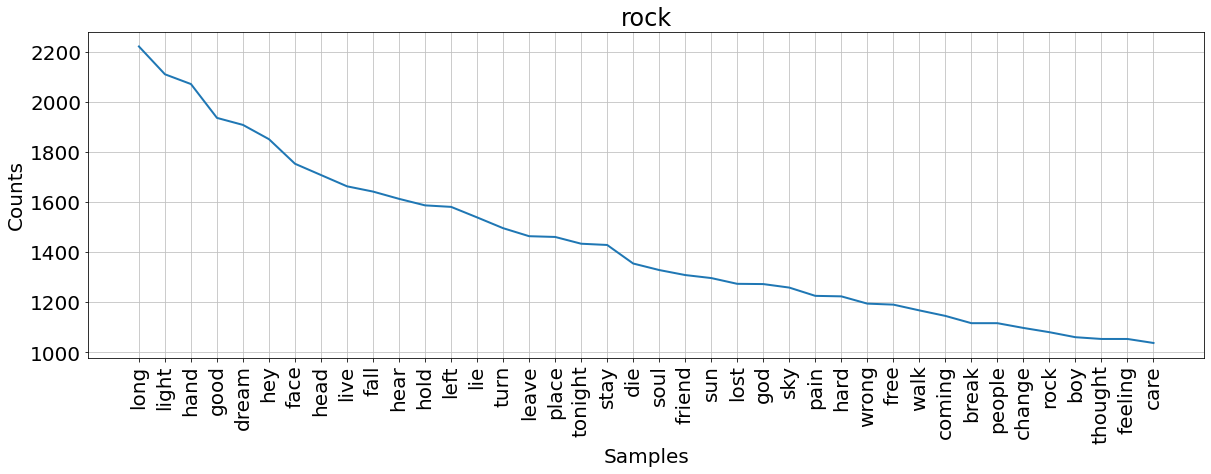

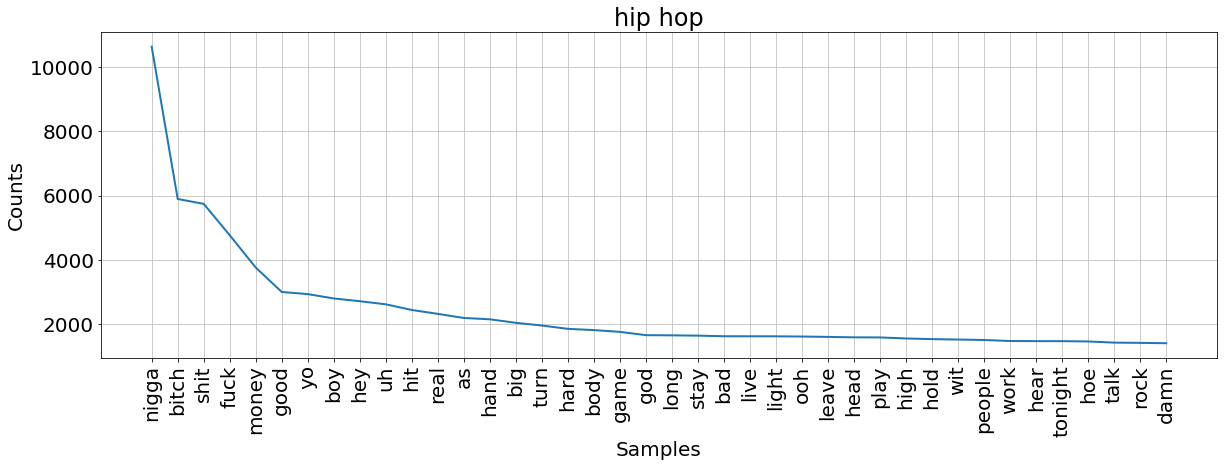

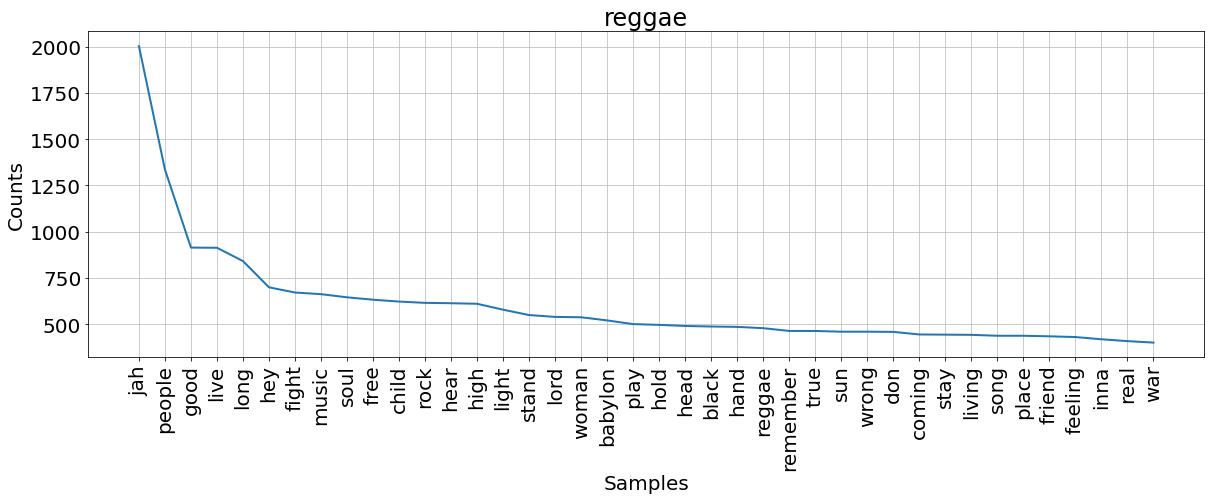

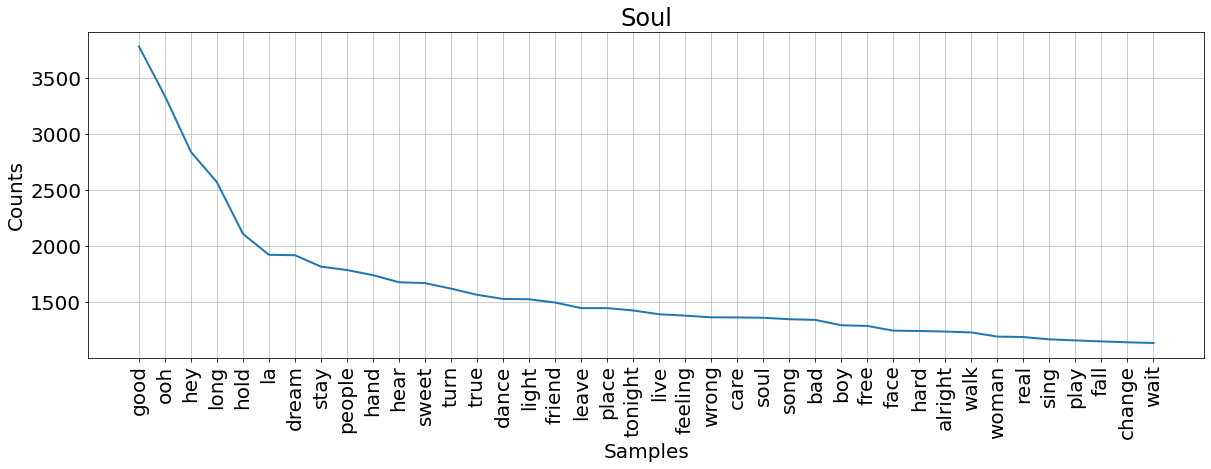

<AxesSubplot:title={'center':'Soul'}, xlabel='Samples', ylabel='Counts'>

In [244]:
fdist_rock = FreqDist(rock_words.split(' '))
fdist_hip_hop = FreqDist(hip_hop_words.split(' '))
# fdist_electronic = FreqDist(electronic_words.split(' '))
fdist_reggae = FreqDist(reggae_words.split(' '))
fdist_soul = FreqDist(soul_words.split(' '))

plt.rcParams.update({'font.size': 20})
plt.subplots(figsize=(20, 6))
fdist_rock.plot(40, title='rock')
plt.subplots(figsize=(20, 6))
fdist_hip_hop.plot(40, title='hip hop')
plt.subplots(figsize=(20, 6))
# fdist_electronic.plot(20, title='electronic')
fdist_reggae.plot(40, title='reggae')
plt.subplots(figsize=(20, 6))
fdist_soul.plot(40, title='Soul')

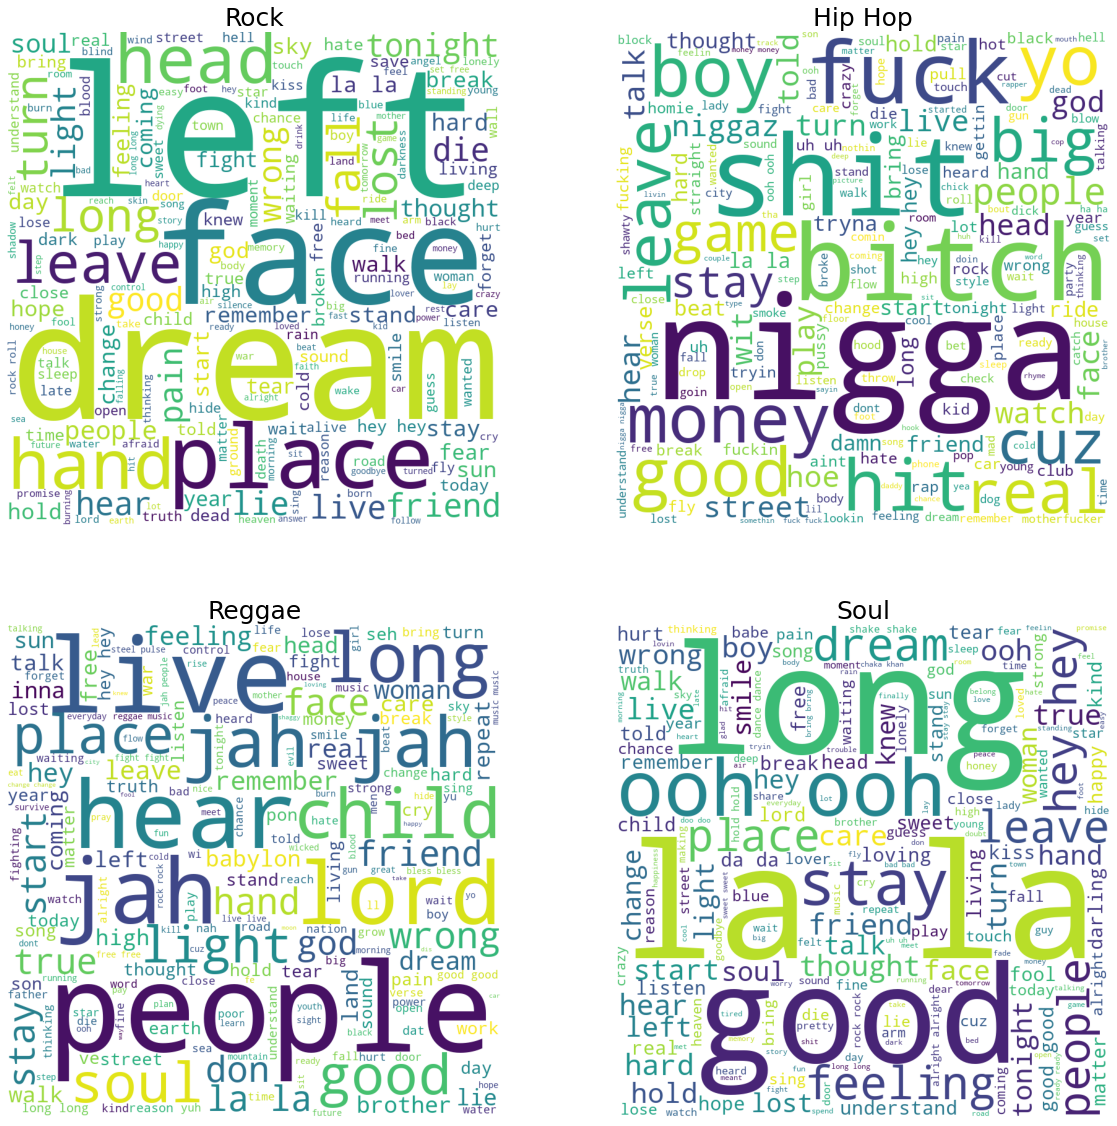

In [245]:
# electronic_words = ' '.join(df[df['Genre']=='Electronic']['Lyrics'])
rock_words = ' '.join(df[df['Genre']=='Rock']['Lyrics'])
hip_hop_words = ' '.join(df[df['Genre']=='Hip Hop']['Lyrics'])
soul_words = ' '.join(df[df['Genre']=='Soul']['Lyrics'])
reggae_words = ' '.join(df[df['Genre']=='Reggae']['Lyrics'])
words_list = [rock_words,hip_hop_words,reggae_words,soul_words]
genres = ['Rock','Hip Hop','Reggae','Soul']
plt.figure(figsize=(20,20)) 
for i in range(1, 5):
    wordcloud = WordCloud(width = 800, height = 800,background_color='white', min_font_size = 10).generate(words_list[i-1]) 
    plt.subplot(2, 2, i)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(genres[i-1],fontsize=25)
    
plt.show()

# Vectorization
Now it's time to vectorize the lyrics such that the columns are words and each cell reprensents the TF-IDF (Term Frequency — Inverse Document Frequency) of a specific word into the text.<br>
This is performed by looking at how many times a word appears into a document while taking into consideration how many times the same word appears in other documents in the corpus.

Let's convert the labels to numerical as below:

In [246]:
# change labels to numerical
y = df['Genre']
y[y=='Rock']=1
y[y=='Hip Hop']=2
y[y=='Reggae']=3
y[y=='Soul']=4
print(y.value_counts())
y = y.tolist()

1    7786
4    7519
2    5841
3    2446
Name: Genre, dtype: int64


I am keeping the words that appears at least in 15 differents lyrics and no more than 0.7 percent of the lyrics.

In [251]:
vec = TfidfVectorizer(min_df=15, max_df=0.7)
X = vec.fit_transform(df['Lyrics'])
df_vec = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())

In [248]:
df_vec.shape

(23592, 6057)

The final step is to split the dataframe into train and test. <br>
I use the SGD Classifier to build the model. It is a linear classifier optimized by Stochastic Gradient Descent.<br>
After trying different algorithms, i got the best scores with this one. 

In [256]:
X_train, X_test, y_train, y_test = train_test_split(df_vec, y , test_size=0.25, random_state=42, shuffle=True)
clf = SGDClassifier()
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           1       0.59      0.74      0.66      1917
           2       0.79      0.71      0.75      1465
           3       0.84      0.41      0.55       632
           4       0.63      0.63      0.63      1884

    accuracy                           0.66      5898
   macro avg       0.71      0.62      0.65      5898
weighted avg       0.68      0.66      0.66      5898



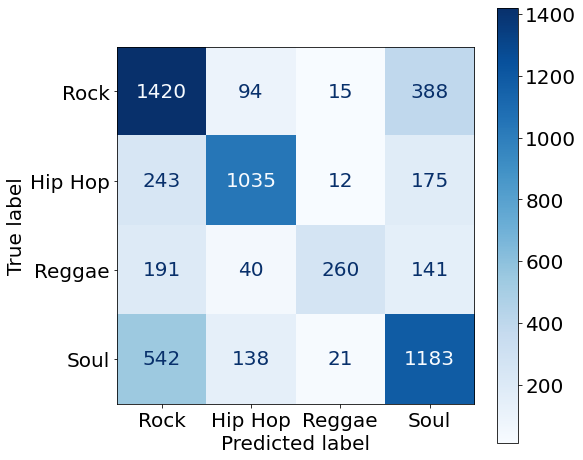

In [257]:
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_test, y_predict)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Rock', 'Hip Hop','Reggae', 'Soul'])
cmd.plot(ax=ax, cmap='Blues')

I got a 0.** overall accuracy.<br>
We can see that the model succeed to differ quite good the Hip Hop and Reggae lyrics genres. <br>
But there is still work to do with the lyrics of Rock and Soul. The model labeled many Rock songs as Soul and vice versa.

There is still some improvements to do but I am quit happy with the results :)